In [1]:
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import string
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import unicodedata

# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('indonesian')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    # text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    # text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

In [5]:
data = pd.read_csv('/content/gdrive/MyDrive/dataset/extractive.csv')
# data['abstractive'] = data['abstractive'].apply(clean_text)

In [6]:
!pip install git+https://github.com/LIAAD/yake

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/LIAAD/yake to /tmp/pip-req-build-1lunazo8
  Running command git clone -q https://github.com/LIAAD/yake /tmp/pip-req-build-1lunazo8


In [7]:
import yake

kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(data['proposed_extractive'][0])

kwy = []
for kw in keywords:
  kwy.append(kw)

In [8]:
sorted(kwy,key=lambda x:(-x[1],x[0]))

[('group saya banyak', 0.053363801344880314),
 ('saya', 0.05236982686247872),
 ('sangat', 0.049976641893433975),
 ('pak budi dan', 0.04748233797708029),
 ('membantu terima ksh', 0.046392537942632935),
 ('dan driver nya', 0.041965018775699435),
 ('terima ksh pak', 0.04180824970250514),
 ('barang group saya', 0.03847743450445122),
 ('driver nya pak', 0.038224025229313306),
 ('sangat membantu terima', 0.037602787379971685),
 ('nya pak bemby', 0.03274617863024596),
 ('terima ksh semua', 0.03241308960288854),
 ('sangat membantu', 0.026630640434083717),
 ('ada mbak rias', 0.02254779968042203),
 ('restoran ada mbak', 0.02254779968042203),
 ('pak bemby brsama', 0.019466507697698348),
 ('bemby brsama teman', 0.015223792241407115),
 ('brsama teman walau', 0.015223792241407115),
 ('teman walau barang', 0.015223792241407115),
 ('walau barang group', 0.015223792241407115)]

In [9]:
from tqdm import tqdm
import yake

def make_keywords(dataset):
  kw_extractor = yake.KeywordExtractor()
  df = pd.DataFrame(columns=['text', 'keywords'])
  df["text"] = dataset["proposed_extractive"]
  df["target"] = dataset["abstractive"] 
  for i in tqdm(range(len(df))):
      keywords = kw_extractor.extract_keywords(df['text'][i])

      kwy = []
      for kw in keywords:
        kwy.append(kw)
      sorted(kwy,key=lambda x:(-x[1],x[0]))

      keyw = []
      for ap_kw in kwy:
        keyw.append(ap_kw[0])

      df["keywords"][i] = keyw

  return df

In [10]:
# from nltk.tokenize import sent_tokenize
# import nltk
# nltk.download('punkt')

# d = {'review':[], 'review_sent':[], 'summary':[]}
# for n in range(len(data)):
#   data_sent = sent_tokenize(data['proposed_extractive'][n])
#   d['review'].append(data['proposed_extractive'][n])
#   d['review_sent'].append(data_sent)
#   d['target'].append(data['abstractive'][n])

In [11]:
# tmp_data = pd.DataFrame(d)

In [12]:
# tmp_data

In [13]:
# tmp_data['review'][0]

In [14]:
# tmp_data['review_sent'][0]

In [15]:
# s = []
# for n in tmp_data['review_sent']:
#   s.append(' [SEP] '.join(n))

In [16]:
# tmp_data['review_sent'] = s

In [17]:
# tmp_data['review_sent'][0]

In [18]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state=42)

In [19]:
train_df

,review,extractive,abstractive,review_cln,extractive_cln,sent_tok,review_key,proposed_extractive
22,Hampir seminggu menginap di Pop Gubeng suraba...,hotel ini memiliki pelayanan yg berbeda denga...,"Hotel ini terletak di Gubeng, Surabaya dengan ...",hampir seminggu menginap di pop gubeng surabay...,hotel ini memiliki pelayanan yg berbeda dengan...,['hampir seminggu menginap di pop gubeng surab...,"Hampir seminggu menginap Pop Gubeng surabaya, ...",surprisingly pihak resepsionis memberikan fre ...
57,Jarang ad hotel yang menyajikan makanan yang ...,Jarang ad hotel yang menyajikan makanan yang ...,Makanan enak dengan ciri khas tertentu. Makana...,jarang ad hotel yang menyajikan makanan yang e...,jarang ad hotel yang menyajikan makanan yang e...,['jarang ad hotel yang menyajikan makanan yang...,Jarang ad hotel menyajikan makanan enak bercit...,hari menginap disini saya sangat terpuaskan de...
50,Pengalaman yg menyenangkan ketika makan siang...,Enak2 semua & pastinya anak2 senang krn bykny...,Makanan di restoran ini rata-rata enak. Tersed...,pengalaman yg menyenangkan ketika makan siang ...,enak semua pastinya anak senang krn byknya cem...,['pengalaman yg menyenangkan ketika makan sian...,Pengalaman yg menyenangkan makan siang keluarg...,hehehe restaurant favorite sima suasana diner ...
33,"Bagi yang biasa di perkotaan, datang ke tempa...","Bagi yang biasa di perkotaan, datang ke tempa...",Dusun bambu memiliki daya tarik untuk menikmat...,bagi yang biasa di perkotaan datang ke tempat ...,bagi yang biasa di perkotaan datang ke tempat ...,['bagi yang biasa di perkotaan datang ke tempa...,"Bagi perkotaan, memanjakan mata. Selain udaran...",dan di sini sepertinya cocok kalau mau foto bu...
39,Gunung Ijen merupakan salah satu tujuan wisat...,Kalau belum naik ke puncaknya belum lengkap r...,Gunung ijen dapat memberikan pemandangan matah...,gunung ijen merupakan salah satu tujuan wisata...,kalau belum naik ke puncaknya belum lengkap ra...,['gunung ijen merupakan salah satu tujuan wisa...,Gunung Ijen salah tujuan wisata Banyuwangi. Ka...,pendakian dimulai bersamaan jadi suasananya ra...
70,Having a great lunch here with teman-teman da...,Impresi pertama ketika memasuki restoran ini ...,Pengunjung mendapat kesan pertama yang menyena...,having a great lunch here with teman teman dar...,impresi pertama ketika memasuki restoran ini a...,['having a great lunch here with teman teman d...,Having a great lunch here with teman-teman per...,pokoknya sepadan bgt buat makan disini friendl...
16,Saya baru pertama kali di Aston cilegon utk k...,Akses lokasi mudah ditemukan. Penerimaan rese...,"Pelayanan dari Hotel Aston Cilegon cepat, solu...",saya baru pertama kali di aston cilegon utk ke...,akses lokasi mudah ditemukan. penerimaan resep...,['saya baru pertama kali di aston cilegon utk ...,Saya kali Aston cilegon utk kepentingan dinas....,kesan pertama kami hotelnya slek dengan tone h...
35,Semoga kita adalah penduduk bumi yang memperh...,"Di Museum Geologi kita dapat bersantai, melih...",Museum geologi memberikan kesan yang menarik u...,semoga kita adalah penduduk bumi yang memperha...,di museum geologi kita dapat bersantai melihat...,['semoga kita adalah penduduk bumi yang memper...,"Semoga penduduk bumi memperhatian planet ini, ...",di museum geologi kita dapat bersantai melihat...
44,Museum Sampoerna atau lebih dikenal dengan Ho...,Bangunan megah dengan gaya kolonial Belanda i...,House of Sampoerna merupakan gedung dengan des...,museum sampoerna atau lebih dikenal dengan hou...,bangunan megah dengan gaya kolonial belanda in...,['museum sampoerna atau lebih dikenal dengan h...,Museum Sampoerna dikenal House of Sampoerna. B...,selain itu disana juga menyediakan tour herita...
61,Steak hut sangat menyenangkan dan saya sangat...,kenapa saya lebih milih di steak hut karena m...,Restoran yang menjadi langganan keluarga karen...,steak hut sangat menyenangkan dan saya sangat ...,kenapa saya lebih milih di steak hut karena ma...,['steak hut sangat menyenan

In [20]:
len(train_df)

58

In [21]:
train_df = make_keywords(train_df.reset_index())
val_df = make_keywords(val_df.reset_index())

100%|██████████| 7/7 [00:00<00:00, 12.91it/s]


In [22]:
train_df

,text,keywords,target
0,surprisingly pihak resepsionis memberikan fre ...,"[menjadi satu bangunan, pop menjadi satu, rese...","Hotel ini terletak di Gubeng, Surabaya dengan ..."
1,hari menginap disini saya sangat terpuaskan de...,"[hari menginap disini, menginap disini saya, t...",Makanan enak dengan ciri khas tertentu. Makana...
2,hehehe restaurant favorite sima suasana diner ...,"[hehehe restaurant favorite, ramai dan berkesa...",Makanan di restoran ini rata-rata enak. Tersed...
3,dan di sini sepertinya cocok kalau mau foto bu...,"[mau foto buat, foto buat preweding, sepertiny...",Dusun bambu memiliki daya tarik untuk menikmat...
4,pendakian dimulai bersamaan jadi suasananya ra...,"[blue fire, jadi suasananya ramai, suasananya ...",Gunung ijen dapat memberikan pemandangan matah...
5,pokoknya sepadan bgt buat makan disini friendl...,"[friendly saat diner, pokoknya sepadan bgt, ru...",Pengunjung mendapat kesan pertama yang menyena...
6,kesan pertama kami hotelnya slek dengan tone h...,"[hitam putih monochrome, hotelnya slek dengan,...","Pelayanan dari Hotel Aston Cilegon cepat, solu..."
7,di museum geologi kita dapat bersantai melihat...,"[mulai jaman prasejarah, bersantai melihat lih...",Museum geologi memberikan kesan yang menarik u...
8,selain itu disana juga menyediakan tour herita...,"[selain itu disana, heritage secara gratis, it...",House of Sampoerna merupakan gedung dengan des...
9,menunya banyak. lengkap enak dan yang pasti ha...,"[menunya banyak, steak, steak hut, hut, yang, ...",Restoran yang menjadi langganan keluarga karen...


In [23]:
!pip install keytotext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
!git clone https://github.com/gagan3012/keytotext.git

fatal: destination path 'keytotext' already exists and is not an empty directory.


In [25]:
%cd /content/keytotext/keytotext

/content/keytotext/keytotext


In [26]:
from trainer import trainer

model=trainer()
model.from_pretrained(model_name='Wikidepia/IndoT5-base')

INFO:lightning_lite.utilities.seed:Global seed set to 42


In [27]:
model.train(train_df=train_df, test_df=val_df, batch_size=4, max_epochs=50, use_gpu=True)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=-1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=-1)` instead.
  rank_zero_deprecation(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  w

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


OutOfMemoryError: ignored

In [ ]:
!pip install datasets==1.9
from datasets import Dataset
train_data = Dataset.from_pandas(train_df)
val_data = Dataset.from_pandas(val_df)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 262 kB 4.5 MB/s 
     |████████████████████████████████| 212 kB 103.8 MB/s 
     |████████████████████████████████| 56 kB 5.6 MB/s 
     |████████████████████████████████| 115 kB 102.7 MB/s 


In [ ]:
!pip install transformers==4.2.1
from transformers import BertTokenizer, GPT2Tokenizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 880 kB 80.1 MB/s 
     |████████████████████████████████| 2.9 MB 88.0 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895260 sha256=0d75daa329ad6d13841e9cf71235232221b28d8cbcc0f39a85d6f0d5d16556c4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses


In [ ]:
tokenizer_src = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
tokenizer_src.bos_token = tokenizer_src.cls_token
tokenizer_src.eos_token = tokenizer_src.sep_token

Downloading:   0%|          | 0.00/229k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

In [ ]:
# make sure GPT2 appends EOS in begin and end
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    outputs = [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    return outputs

In [ ]:
GPT2Tokenizer.build_inputs_with_special_tokens = build_inputs_with_special_tokens
tokenizer_tgt = GPT2Tokenizer.from_pretrained("cahya/gpt2-small-indonesian-522M")
tokenizer_tgt.pad_token = tokenizer_tgt.unk_token

Downloading:   0%|          | 0.00/894k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/452k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/357 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/16.0 [00:00<?, ?B/s]

In [ ]:
data

,review,extractive,abstractive,review_cln,extractive_cln,sent_tok,review_key,proposed_extractive
0,Saya stay disana selama 4 hari untuk urusan b...,Saat saya datang disambut oleh receptionis yg...,Hotel terletak dekat bandara. Pelayanan yang d...,saya stay disana selama hari untuk urusan bisn...,saat saya datang disambut oleh receptionis yg ...,['saya stay disana selama hari untuk urusan bi...,Saya stay disana 4 urusan bisnis. Saat disambu...,terima ksh semua staf yg sngt membantu d resto...
1,Menginap satu malam untuk merayakan ultah ank...,"Kami dpt kmr yg type leopard , bangunanny ban...",Hotel unik dengan tema kebun binatang. Tidak h...,menginap satu malam untuk merayakan ultah ank ...,kami dpt kmr yg type leopard bangunany banguna...,['menginap satu malam untuk merayakan ultah an...,Menginap malam merayakan ultah ank yg ptama d ...,ad wahana bumper car farm kart biliard untuk o...
2,Sangat senang bisa kembali lagi ke hotel muli...,kita pilih mulia bali yg memang sudah jadi pi...,Pelayanan sangat baik secara keseluruhan dari ...,sangat senang bisa kembali lagi ke hotel mulia...,kita pilih mulia bali yg memang sudah jadi pil...,['sangat senang bisa kembali lagi ke hotel mul...,Sangat senang hotel mulia pandemi sekeluarga b...,anak anak juga sangat senang menikmati waktu d...
3,"Hotel Veranda, amazing n cozy banget. Bebera...","Hotel Veranda, amazing n cozy banget. Ruang m...",Hotel memberikan pengalaman yang menyenangkan ...,hotel veranda amazing n cozy banget. beberapa ...,hotel veranda amazing n cozy banget. ruang met...,"['hotel veranda amazing n cozy banget', 'beber...","Hotel Veranda, amazing n cozy banget. Beberapa...",pegawai hotel nya sangat ramah dan membantu. r...
4,Menginap pada akhir pekan bersama suami dan a...,"Secara lokasi, hotel ini sangat strategis, de...",Hotel ini berada di Kota Bogor dengan penempat...,menginap pada akhir pekan bersama suami dan an...,secara lokasi hotel ini sangat strategis deket...,['menginap pada akhir pekan bersama suami dan ...,Menginap pekan suami anak usia 2tahun. Secara ...,kami menginap di kamar type deluxe balcony int...
...,...,...,...,...,...,...,...,...
68,Cari tempat makan santai di bandung buat meet...,Oh iya sewaktu disini dilayanin secara ramah ...,Restoran memberikan suasana yang nyaman. Apala...,cari tempat makan santai di bandung buat metin...,oh iya sewaktu disini dilayanin secara ramah b...,['cari tempat makan santai di bandung buat met...,"Cari makan santai bandung meeting tim, fotogra...",you have to try this stomach catching place an...
69,"Pada saat saya berkunjung ke kota solo, saya ...",Salah satu yang dipuja-puja di banyak artikel...,Pengunjung bingung dengan lokasi warung nasi l...,pada saat saya berkunjung ke kota solo saya me...,salah satu yang dipuja puja di banyak artikel ...,['pada saat saya berkunjung ke kota solo saya ...,"Pada berkunjung kota solo, mencari referensi k...",harga makanannya menurutku mahal untuk kota so...
70,Having a great lunch here with teman-teman da...,Impresi pertama ketika memasuki restoran ini ...,Pengunjung mendapat kesan pertama yang menyena...,having a great lunch here with teman teman dar...,impresi pertama ketika memasuki restoran ini a...,['having a great lunch here with teman teman d...,Having a great lunch here with teman-teman per...,pokoknya sepadan bgt buat makan disini friendl...
71,"Saya datang di hari kerja,sekitar jam 7 malam...",saya mencoba tenderloin steak dgn mashed pota...,Salah satu steak enak dan variatif. Daging ste...,saya datang di hari kerja sekitar jam malam.lo...,saya mencoba tenderloin steak dgn mashed potat...,['saya datang di hari kerja sekitar jam malam'...,"Saya kerja,sekitar jam 7 malam.lokasi terlewat...",harganya terjangkau pelayanya ramah. pizanya p...


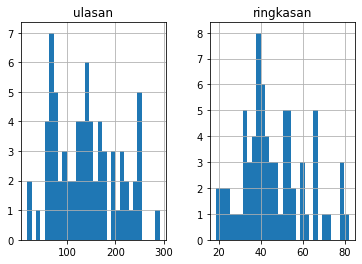

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in tmp_data['review']:
      text_word_count.append(len(i.split()))

for i in tmp_data['summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'ulasan':text_word_count, 'ringkasan':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [ ]:
max_ulasan = max(text_word_count)
print(max_ulasan)
max_ringkasan = max(summary_word_count)
print(max_ringkasan)

291
82


In [ ]:
encoder_max_length = max_ulasan
decoder_max_length = max_ringkasan

def process_data_to_model_inputs(batch):
  # tokenize the inputs and labels
  inputs = tokenizer_src(batch["review_sent"], padding="max_length", truncation=True, max_length=encoder_max_length)
  outputs = tokenizer_tgt(batch["summary"], padding="max_length", truncation=True, max_length=decoder_max_length)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask
  batch["decoder_input_ids"] = outputs.input_ids
  batch["labels"] = outputs.input_ids.copy()
  batch["decoder_attention_mask"] = outputs.attention_mask

  batch["labels"] = [
        [-100 if mask == 0 else token for mask, token in mask_and_tokens] for mask_and_tokens in [zip(masks, labels) for masks, labels in zip(batch["decoder_attention_mask"], batch["labels"])]
    ]
  
  assert all([len(x) == encoder_max_length for x in inputs.input_ids])
  assert all([len(x) == decoder_max_length for x in outputs.input_ids])
  return batch

In [ ]:
batch_size=32

train_data = train_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    # remove_columns=["review", "extractive", "review_cln", "extractive_cln", "sent_tok", "review_key"]
)
val_data = val_data.map(
    process_data_to_model_inputs, 
    batched=True, 
    batch_size=batch_size, 
    # remove_columns=["review", "extractive", "review_cln", "extractive_cln", "sent_tok", "review_key"]
)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
train_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

val_data.set_format(
    type="torch", columns=["input_ids", "attention_mask", "decoder_input_ids", "decoder_attention_mask", "labels"],
)

In [ ]:
train_data[0]

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0

In [ ]:
from transformers import EncoderDecoderModel

bert2gpt = EncoderDecoderModel.from_encoder_decoder_pretrained("indobenchmark/indobert-base-p1","cahya/gpt2-small-indonesian-522M")

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/498M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/573 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/510M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at cahya/gpt2-small-indonesian-522M and are newly initialized: ['transformer.h.0.crossattention.bias', 'transformer.h.0.crossattention.masked_bias', 'transformer.h.0.crossattention.c_attn.weight', 'transformer.h.0.crossattention.c_attn.bias', 'transformer.h.0.crossattention.q_attn.weight', 'transformer.h.0.crossattention.q_attn.bias', 'transformer.h.0.crossattention.c_proj.weight', 'transformer.h.0.crossattention.c_proj.bias', 'transformer.h.0.ln_cross_attn.weight', 'transformer.h.0.ln_cross_attn.bias', 'transformer.h.1.crossattention.bias', 'transformer.h.1.crossattention.masked_bias', 'transformer.h.1.crossattention.c_attn.weight', 'transformer.h.1.crossattention.c_attn.bias', 'transformer.h.1.crossattention.q_attn.weight', 'transformer.h.1.crossattention.q_attn.bias', 'transformer.h.1.crossattention.c_proj.weight', 'transformer.h.1.crossattention.c_proj.bias', 'transformer.h.1.ln_cross_attn.weight', 'tran

In [ ]:
# for layer in bert2gpt.encoder.encoder.layer[1:]:
#   for param in layer.parameters():
#     param.requires_grad = False

In [ ]:
# for layer in bert2gpt.encoder.encoder.layer:
#   for param in layer.parameters():
#     print(param.requires_grad)

In [ ]:
# bert2gpt

In [ ]:
# bert2gpt.config.decoder.eos_token_id

In [ ]:
bert2gpt.config.decoder_start_token_id = tokenizer_tgt.bos_token_id
bert2gpt.config.eos_token_id = tokenizer_tgt.eos_token_id
bert2gpt.config.pad_token_id = tokenizer_tgt.pad_token_id
bert2gpt.config.max_length = 20
bert2gpt.config.min_length = 3
bert2gpt.config.no_repeat_ngram_size = 3
bert2gpt.early_stopping = True
bert2gpt.length_penalty = 2.0
bert2gpt.num_beams = 8

In [ ]:
!pip install rouge_score
from datasets import load_metric

rouge = load_metric("rouge")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=ba74e15189641e893578b050ea94a3412778990f7c690a8370e3c1772bfc8a90
  Stored in directory: /root/.cache/pip/wheels/84/ac/6b/38096e3c5bf1dc87911e3585875e21a3ac610348e740409c76
Successfully built rouge-score


Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

In [ ]:
def rouge_matrix(pred, ref):
  result = rouge.compute(predictions=pred, references=ref)
  rouge1 = result['rouge1'].mid
  rouge2 = result['rouge2'].mid
  rougeL = result['rougeL'].mid

  return {
      "rouge1_fmeasure": round(rouge1.fmeasure, 4),
      "rouge2_fmeasure": round(rouge2.fmeasure, 4),
      "rougeL_fmeasure": round(rougeL.fmeasure, 4),
  }

In [ ]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = tokenizer_tgt.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = tokenizer_tgt.pad_token_id
    label_str = tokenizer_tgt.batch_decode(labels_ids, skip_special_tokens=True)

    result = rouge_matrix(pred_str, label_str)

    return result

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    # fp16=True, 
    output_dir="./",
    do_train=True,
    do_eval=True,
    logging_steps=50,  
    save_steps=32, 
    # warmup_steps=50,  
    # max_steps=1500, # delete for full training
    num_train_epochs = 128, #TRAIN_EPOCHS
    # save_total_limit=1,
)

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=bert2gpt,
    tokenizer=tokenizer_tgt,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=val_data,
)
trainer.train()

Step,Training Loss,Validation Loss,Rouge1 Fmeasure,Rouge2 Fmeasure,Rougel Fmeasure,Runtime,Samples Per Second
50,1.213700,4.897619,0.167500,0.019700,0.118600,5.616000,1.246000
100,0.011400,5.266164,0.153700,0.019900,0.119800,5.218000,1.342000
150,0.002700,5.392622,0.173200,0.028400,0.142900,5.270600,1.328000
200,0.001900,5.420524,0.140900,0.008400,0.119800,5.692300,1.230000
250,0.001500,5.448180,0.165400,0.028400,0.137800,5.262700,1.330000


INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.


TrainOutput(global_step=256, training_loss=0.24051399156451225, metrics={'train_runtime': 3100.8877, 'train_samples_per_second': 0.083, 'total_flos': 4606451122176000, 'epoch': 128.0})

In [ ]:
trainer.save_model('/content/gdrive/MyDrive/Colab Notebooks/tesis/bert2gpt-sep')

In [ ]:
model = EncoderDecoderModel.from_pretrained('/content/gdrive/MyDrive/Colab Notebooks/tesis/bert2gpt-sep')

In [ ]:
test_data = Dataset.from_pandas(test_df)

batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer_src(batch["review"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    outputs = model.generate(input_ids, max_length=decoder_max_length, attention_mask=attention_mask, num_beams=10,
                                repetition_penalty=5.0, num_return_sequences=1)

    # all special tokens including will be removed
    output_str = tokenizer_tgt.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [ ]:
results = test_data.map(generate_summary, batched=True, batch_size=batch_size)
pred_str = results["pred"]
label_str = results["summary"]

rouge_output = rouge_matrix(pred_str, label_str)
print(rouge_output)

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:absl:Using default tokenizer.


{'rouge1_fmeasure': 0.2674, 'rouge2_fmeasure': 0.0531, 'rougeL_fmeasure': 0.1677}


In [ ]:
for i in range(len(test_data)):
    print('ulasan: ',test_data[i]["review"])
    print('ringkasan: ',label_str[i])
    print('prediksi: ',pred_str[i])
    print("===================")

ulasan:  selalu rame pas sarapan dan makan siang. soto ayam bening porsinya pas tdk terlalu kecil dengan berbagai pilihan lauk tersedia di meja. salah satu restoran soto yang kami coba di solo. tambahan lauk ada sate paru sate usus perkedel ote dl dengan harga mulai rp. sotonya sih biasa minimalis cokotan seperti sate paru otak goreng sate kikil empal dan rombongan kolesterol lainnya bikin soto jadi lebih nikmat.
ringkasan:  Rumah makan soto yang menjadi langganan presiden pak jokowi. Lokasi dekat dengan alun-alun. Sotonya enak ditambah lauk yang bermacam-macam seperti sate paru menambah kenikmatan. Harga terjangkau. Tempat selalu ramai sehingga sulit untuk mencari meja dan kursi. Namun semua teratasi dengan pelayanan staf yang tanggap dan ramah.
prediksi:  Jenis makanan sangat variatif mulai dari sunda, eropa, dan asia timur. Ada beberapa makanan yang kurang enak yaitu steak dan sushi. Kedua makanan itu keras. Minuman kopi, teh, dan juice juga variatif. Pengunjung dapat melihat pemand

In [ ]:
test_data = Dataset.from_pandas(test_df)

batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary_beam(batch):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer_src(batch["proposed_extractive"], padding="max_length", truncation=True, max_length=encoder_max_length, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    outputs = model.generate(input_ids, max_length=decoder_max_length, attention_mask=attention_mask, num_beams=10)

    # all special tokens including will be removed
    output_str = tokenizer_tgt.batch_decode(outputs, skip_special_tokens=True)

    batch["pred"] = output_str

    return batch

In [ ]:
resultsb = test_data.map(generate_summary_beam, batched=True, batch_size=batch_size, remove_columns=["review", "extractive", "proposed_extractive", "extractive_cln", "sent_tok", "review_key"])
pred_strb = resultsb["pred"]
label_strb = resultsb["abstractive"]

rouge_output = rouge_matrix(pred_strb, label_strb)
print(rouge_output)

  0%|          | 0/1 [00:00<?, ?ba/s]

INFO:absl:Using default tokenizer.


{'rouge1_fmeasure': 0.2582, 'rouge2_fmeasure': 0.0467, 'rougeL_fmeasure': 0.1524}


In [ ]:
rslt.to_excel('/content/gdrive/MyDrive/Colab Notebooks/result.xlsx')

In [ ]:
batch_size = 16  # change to 64 for full evaluation

# map data correctly
def generate_summary(text):
    # Tokenizer will automatically set [BOS] <text> [EOS]
    # cut off at BERT max length 512
    inputs = tokenizer_src(text, padding="max_length", truncation=True, max_length=70, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask

    outputs = model.generate(input_ids, attention_mask=attention_mask)

    # all special tokens including will be removed
    output_str = tokenizer_tgt.batch_decode(outputs, skip_special_tokens=True)

    

    return output_str

# results = test_data.map(generate_summary, batched=True, batch_size=batch_size, remove_columns=["ulasan"])

# pred_str = results["pred"]
# label_str = results["ringkasan"]

# rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
x = generate_summary('Hotelnya dekat banget sama kuta, nyaman dan lobbynya bagus.')
print(x)

['lokasi strategis dan hotel nyaman']


In [ ]:
print(rouge_output)

Score(precision=0.0, recall=0.0, fmeasure=0.0)


In [ ]:
test_data = Dataset.from_pandas(test_df)
test_data = test_data.select(range(30))

max_ulasan_len=70
max_ringkasan_len=14

def generate_summary(batch):
    inputs = tokenizer(batch["ulasan"], padding="max_length", truncation=True, max_length=max_ulasan_len, return_tensors="pt")
    input_ids = inputs.input_ids
    attention_mask = inputs.attention_mask
    outputs = model.generate(input_ids, attention_mask=attention_mask)
    batch["pred"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

results = test_data.map(generate_summary, batched=True, batch_size=4, remove_columns=["ulasan"])

pred_str = results["pred"]
label_str = results["ringkasan"]

rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rouge2"])["rouge2"].mid
rouge_output = rouge.compute(predictions=pred_str, references=label_str, rouge_types=["rougeL"])["rougeL"].mid
print(rouge_output)

  0%|          | 0/8 [00:00<?, ?ba/s]

/usr/local/lib/python3.7/dist-packages/transformers/generation_utils.py:1207: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 70 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  UserWarning,


Score(precision=0.003138943460670141, recall=0.03611111111111111, fmeasure=0.005720116401230952)


In [ ]:
device = torch.device("cpu")
def train(
    args,
    model: EncoderDecoderModel,
    train_dataloader,
    eval_dataloader,
    optimizer,
    scheduler,
    src_tokenizer,
    tgt_tokenizer,
):
    eval_bleu = -1
    for epoch in range(args.nepoch):
        step = 0
        total_batch = train_dataloader.__len__()
        for data in train_dataloader:
            (
                input_ids,
                attention_mask,
                decoder_input_ids,
                decoder_attention_mask,
                labels,
            ) = data
            outputs = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
                decoder_input_ids=decoder_input_ids.to(device),
                decoder_attention_mask=decoder_attention_mask.to(device),
                labels=labels.to(device),
                return_dict=True,
            )
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            step += 1
            model.zero_grad()
            if args.ngpu > 1:
                reduced_loss = reduce_tensor(loss).cpu().item()
            else:
                reduced_loss = loss.cpu().item()
            if local_rank == 0 or local_rank == -1:
                lr, finetune_lr = scheduler.get_lr()[0], scheduler.get_lr()[1]
                print(
                    "\rstep:{}/{}, bleu:{} loss:{}, lr:{}, ft.lr:{}".format(
                        step,
                        total_batch,
                        round(eval_bleu, 4),
                        round(reduced_loss, 4),
                        round(lr, 6),
                        round(finetune_lr, 6),
                    ),
                    end="",
                )
                writer.add_scalar("loss", reduced_loss, int(step * (1 + epoch)))
                writer.add_scalar("lr", lr, int(step * (1 + epoch)))
                writer.add_scalar("finetune_lr", finetune_lr, int(step * (1 + epoch)))
                if step % args.save_step == 0 or step % total_batch == 0:
                    eval_bleu = eval(
                        model, eval_dataloader, tgt_tokenizer, args.max_src_len
                    )
                    writer.add_scalar("bleu", eval_bleu, int(step * (1 + epoch)))
                    model_to_save = model.module if hasattr(model, "module") else model
                    save_model(
                        args,
                        model_to_save,
                        optimizer,
                        src_tokenizer,
                        tgt_tokenizer,
                        step,
                        epoch,
                        eval_bleu,
                        reduced_loss,
                    )


In [ ]:
def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
    if token_ids_1 is None:
        return [self.bos_token_id] + token_ids_0 + [self.eos_token_id]
    bos = [self.bos_token_id]
    eos = [self.eos_token_id]
    return bos + token_ids_0 + eos + token_ids_1 + eos

In [ ]:
import types

tgt_tokenizer.add_special_tokens(
            {"bos_token": "[BOS]", "eos_token": "[EOS]", "pad_token": "[PAD]"}
        )
tgt_tokenizer.build_inputs_with_special_tokens = types.MethodType(
            build_inputs_with_special_tokens, tgt_tokenizer
        )

In [ ]:
from transformers import (
    BertGenerationConfig,
    BertGenerationEncoder,
    BertTokenizer,
    EncoderDecoderModel,
    EncoderDecoderConfig,
    BertLMHeadModel,
    GPT2Tokenizer,
    Trainer,
    TrainingArguments,
    get_cosine_schedule_with_warmup,
)

encoder = BertGenerationEncoder.from_pretrained("indolem/indobert-base-uncased")
decoder = BertLMHeadModel.from_pretrained(
            "indolem/indobert-base-uncased", add_cross_attention=True, is_decoder=True
        )
decoder.resize_token_embeddings(len(tgt_tokenizer))
decoder.config.bos_token_id = tgt_tokenizer.bos_token_id
decoder.config.eos_token_id = tgt_tokenizer.eos_token_id
decoder.config.vocab_size = len(tgt_tokenizer)
decoder.config.add_cross_attention = True
decoder.config.is_decoder = True

model_config = EncoderDecoderConfig.from_encoder_decoder_configs(encoder.config, decoder.config)
model = EncoderDecoderModel( encoder=encoder, decoder=decoder, config=model_config)

You are using a model of type bert to instantiate a model of type bert-generation. This is not supported for all configurations of models and can yield errors.


Some weights of the model checkpoint at indolem/indobert-base-uncased were not used when initializing BertGenerationEncoder: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'bert.pooler.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'bert.pooler.dense.bias', 'bert.embeddings.token_type_embeddings.weight']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel w